### <b><span style="color:orange">About Dataset
<b>Context</b>
Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. This dataset describes the listing activity and metrics in NYC, NY for 2019.

<b>Content</b>
This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions.

<b>Acknowledgements</b>
This public dataset is part of Airbnb, and the original source can be found on this website.

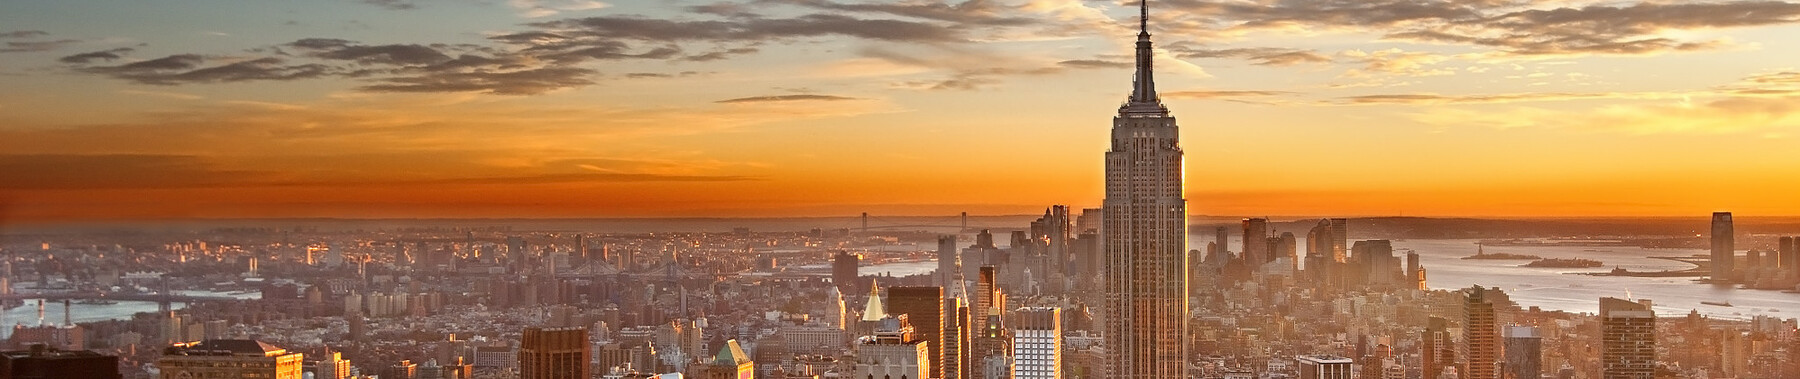

### <b><span style="color:orange">Packages

In [141]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.api as sm
import statsmodels.formula.api as sm2


from scipy.stats import kruskal
from scipy import stats


import warnings
warnings.simplefilter(action='ignore')

### <b><span style="color:orange">Exploratory Analysis

In [2]:
df_ny = pd.read_csv('AB_NYC_2019.csv')
df_ny.head(4)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


Dataset count:
Rows: 48895
Columns:  16
----------------------------------------
Dtypes Info:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object
----------------------------------------
Unique values:
id                                48895
name                              47905
host_id                           37457
host_name                         11452
neig

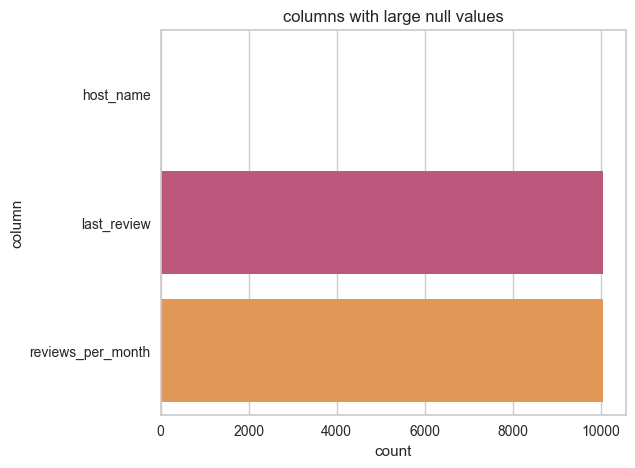

In [3]:
print('\033[1mDataset count:\033[0m')
print("Rows:",df_ny.shape[0]) ; print("Columns: ",df_ny.shape[1])
print("-"*40)
print("\033[1mDtypes Info:\033[0m") ; print(df_ny.dtypes)
print("-"*40)
print('\033[1mUnique values:\033[0m') ; print(df_ny.nunique())
print("-"*40)
print("\033[1mDuplicate values: \033[0m") ; print(df_ny.duplicated().sum())
print("-"*40)
print("\033[1mNull values: \033[0m") ; print(df_ny.isnull().sum())
null = df_ny.isnull().sum().reset_index()
null.columns = ['column','count']
null = null.loc[null['count'] > 19]
print('\033[1mGraph view:\033[0m')
plt.figure(figsize=(6, 5))
sns.barplot(y=null['column'], x=null['count'], palette='plasma')
plt.xlabel('count')
plt.ylabel('column')
plt.title('columns with large null values')
plt.show()

With this first analysis we can verify that
* there are no duplicate values
* last_review and reviews_per_month have many null values
* the columns do not need transformation, their types are correct

We will delete the columns that we will not use and columns with large null values.

In [4]:
for column in df_ny.columns:
    check = df_ny[column].isnull().sum()
    if check > 20:
        df_ny.drop(column,axis=1,inplace=True)
df_ny.drop(['id','host_id'],axis=1, inplace=True)

In [5]:
da_ny = df_ny.drop_duplicates()

In [6]:
df_ny.isnull().sum()

name                              16
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

#### Initial statistical analysis

<span style="color:yellow">To numeric variables we can analyse:</span>
 * Central Tendency: Mean, Median
 * Variability: Standard deviation, Variance
 * Divisions: Quartiles, Amplitudes

<span style="color:green">To categorical variables we can analyse:</span>
 * Central Tendency: Mode

In [7]:
df_ny.describe(include='object')

,name,neighbourhood_group,neighbourhood,room_type
count,48879,48895,48895,48895
unique,47905,5,221,3
top,Hillside Hotel,Manhattan,Williamsburg,Entire home/apt
freq,18,21661,3920,25409


In [8]:
print("\033[1;32;40m We can check the mode for each type of room and neighbourhood group\033[0m")
for column in df_ny[['room_type','neighbourhood_group']]:
    print(f"\033[1mValue counts to: {column}\033[0m")
    print(df_ny[column].value_counts())
    print()

 We can check the mode for each type of room and neighbourhood group
Value counts to: room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

Value counts to: neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64



In [9]:
print("\033[1;32;40m We can check the neighbourhood mode for each group of neighbourhood group\033[0m")

ny_copy = df_ny.copy()
man   =   ny_copy[['neighbourhood','neighbourhood_group','price','room_type']].loc[ny_copy['neighbourhood_group'] == 'Manhattan']
brook =   ny_copy[['neighbourhood','neighbourhood_group','price','room_type']].loc[ny_copy['neighbourhood_group'] == 'Brooklyn']
queens=   ny_copy[['neighbourhood','neighbourhood_group','price','room_type']].loc[ny_copy['neighbourhood_group'] == 'Queens']
bronx =   ny_copy[['neighbourhood','neighbourhood_group','price','room_type']].loc[ny_copy['neighbourhood_group'] == 'Bronx']
stti  =   ny_copy[['neighbourhood','neighbourhood_group','price','room_type']].loc[ny_copy['neighbourhood_group'] == 'Staten Island']
listt = [man, brook,queens,bronx,stti]

for neigh in listt:
    print(f"\033[1mNeighborhood mode to: {neigh.iloc[0,1]}\033[0m")
    print(neigh['neighbourhood'].value_counts().head(5))
    print("-"*40)
    

 We can check the neighbourhood mode for each group of neighbourhood group
Neighborhood mode to: Manhattan
Harlem             2658
Upper West Side    1971
Hell's Kitchen     1958
East Village       1853
Upper East Side    1798
Name: neighbourhood, dtype: int64
----------------------------------------
Neighborhood mode to: Brooklyn
Williamsburg          3920
Bedford-Stuyvesant    3714
Bushwick              2465
Crown Heights         1564
Greenpoint            1115
Name: neighbourhood, dtype: int64
----------------------------------------
Neighborhood mode to: Queens
Astoria             900
Long Island City    537
Flushing            426
Ridgewood           423
Sunnyside           363
Name: neighbourhood, dtype: int64
----------------------------------------
Neighborhood mode to: Bronx
Kingsbridge    70
Fordham        63
Longwood       62
Mott Haven     60
Concourse      50
Name: neighbourhood, dtype: int64
----------------------------------------
Neighborhood mode to: Staten Island
St. 

In [10]:
print("\033[1;32;40m We can check the room_type mode for each group of neighbourhood group\033[0m")
for neigh in listt:
    print(f"\033[1mRoom Type mode to: {neigh.iloc[0,1]}\033[0m")
    print(neigh['room_type'].value_counts().head(5))
    print("-"*40)

 We can check the room_type mode for each group of neighbourhood group
Room Type mode to: Manhattan
Entire home/apt    13199
Private room        7982
Shared room          480
Name: room_type, dtype: int64
----------------------------------------
Room Type mode to: Brooklyn
Private room       10132
Entire home/apt     9559
Shared room          413
Name: room_type, dtype: int64
----------------------------------------
Room Type mode to: Queens
Private room       3372
Entire home/apt    2096
Shared room         198
Name: room_type, dtype: int64
----------------------------------------
Room Type mode to: Bronx
Private room       652
Entire home/apt    379
Shared room         60
Name: room_type, dtype: int64
----------------------------------------
Room Type mode to: Staten Island
Private room       188
Entire home/apt    176
Shared room          9
Name: room_type, dtype: int64
----------------------------------------


In [11]:
print("\033[1;32;40m Places that appear most\033[0m")
df_ny['name'].value_counts().head(5)

 Places that appear most


Hillside Hotel                      18
Home away from home                 17
New york Multi-unit building        16
Brooklyn Apartment                  12
Loft Suite @ The Box House Hotel    11
Name: name, dtype: int64

<b><span style="color:purple">Conclusion about top 2 neighborhoods group which represent 85.4% of the dataset</span></b>

* <b>Manhattan</b><br>
Harlem leads with the highest number of listings, indicating a significant demand or supply in this area. This might be due to its rich cultural heritage and comparatively lower rental prices than other popular neighborhoods like Upper West Side and Hell's Kitchen closest to tourist attractions. 
The preference in Manhattan leans heavily towards entire homes/apartments, reflecting the demand for privacy and convenience among renters in this busy and densely populated borough.

* <b>Brooklyn</b><br>
Williamsburg and Bedford-Stuyvesant dominate the Brooklyn rental market. Williamsburg's popularity is likely due to its trendy vibe, nightlife, and proximity to Manhattan. Bedford-Stuyvesant’s high numbers suggest its growing popularity.
Brooklyn shows a preference for private rooms, which may indicate a more budget-conscious renter demographic or a larger number of hosts renting out parts of their homes.

In [12]:
print("\033[1;33;40m Describe through most important numerical variables\033[0m");
dsc = df_ny.describe().drop(['count'],axis=0)
dsc.loc['var'] =  dsc.loc['std'] * dsc.loc['std']
dsc.loc['amplitude'] = dsc.loc['max'] -  dsc.loc['min']
dsc.rename(index={'25%': 'first quartile', '50%': 'second quartile', '75%':'third quartile'})

 Describe through most important numerical variables


,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
first quartile,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
second quartile,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
third quartile,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000
var,0.002974,0.002130,57674.025247,420.682642,1984.754380,1085.868499,17324.426923
amplitude,0.413270,0.531430,10000.000000,1249.000000,629.000000,326.000000,365.000000


In [13]:
print("\033[1;33;40m Price Mean through neighborhoods\033[0m");
neighs = df_ny[['price','neighbourhood_group']].groupby('neighbourhood_group').agg({"price": [np.mean, 'median','min','max']})
neighs

 Price Mean through neighborhoods


price                  
                           mean median min    max
neighbourhood_group                              
Bronx                 87.496792   65.0   0   2500
Brooklyn             124.383207   90.0   0  10000
Manhattan            196.875814  150.0   0  10000
Queens                99.517649   75.0  10  10000
Staten Island        114.812332   75.0  13   5000

<b><span style="color:purple">Conclusions</span></b>
* Manhattan has the highest average price among all neighbourhood groups, followed by Brooklyn and Queens. Due to the existence of outliers we can look at the median of the data in this case
* The Bronx has the lowest average price, but it also has the lowest maximum price, indicating a narrower price range compared to other boroughs.
* Brooklyn and Manhattan has the highest maximum price, suggesting a wider range of prices and potentially more luxury accommodations.

<b><span style="color:red">Note: </span></b>Assuming that there are outliers and the data distribution is not normal and we cant use a Anova test for the means for example, we can use a non-parametric test to test whether there are significant differences in the median prices of the 5 groups of neighborhoods. The test chosen was the Kruskal-Wallis test due to the independent nature of the groups.

In [145]:
print("\033[1;33;40m We can test the hypothesis if the medians of each group have significant differences\033[0m");
arr1 = np.array([price for price, group in zip(df_ny['price'].values, df_ny['neighbourhood_group'].values) if group == 'Bronx'])
arr2 = np.array([price for price, group in zip(df_ny['price'].values, df_ny['neighbourhood_group'].values) if group == 'Brooklyn'])
arr3 = np.array([price for price, group in zip(df_ny['price'].values, df_ny['neighbourhood_group'].values) if group == 'Manhattan'])
arr4 = np.array([price for price, group in zip(df_ny['price'].values, df_ny['neighbourhood_group'].values) if group == 'Queens'])
arr5 = np.array([price for price, group in zip(df_ny['price'].values, df_ny['neighbourhood_group'].values) if group == 'Staten Island'])

stat, p_value = kruskal(arr1,arr2,arr3,arr4,arr5)

alpha = 0.05
if p_value < alpha:
    print("Null hypothesis rejected, there is a significant difference")
else:
    print("We do not have enough evidence to reject the null hypothesis")

print(f'p-value: {p_value}')

 We can test the hypothesis if the medians of each group have significant differences
Null hypothesis rejected, there is a significant difference
p-value: 0.0


In [14]:
def median(column):
    return column.quantile(0.5)

print("\033[1;33;40m With the previous analysis of neighboorhod groups, we will check the average prices for the most popular neighborhoods in Manhattan and Brooklyn\033[0m");
man_brook = ny_copy[['neighbourhood','price','neighbourhood_group']].loc[ny_copy['neighbourhood'].isin(['Harlem','Upper West Side',"Hell's Kitchen",'Williamsburg','Bedford-Stuyvesant','Bushwick'])]
man_brook.groupby(['neighbourhood_group','neighbourhood']).agg({'price':[np.mean,median,'min','max','std']})

 With the previous analysis of neighboorhod groups, we will check the average prices for the most popular neighborhoods in Manhattan and Brooklyn


price                    \
                                              mean median min    max   
neighbourhood_group neighbourhood                                      
Brooklyn            Bedford-Stuyvesant  107.678244   80.0   0   5000   
                    Bushwick             84.800406   65.0   0   2000   
                    Williamsburg        143.802806  105.0   0   4500   
Manhattan           Harlem              118.974041   89.0  10   5000   
                    Hell's Kitchen      204.794178  168.0  10   4100   
                    Upper West Side     210.918316  150.0  10  10000   

                                                    
                                               std  
neighbourhood_group neighbourhood                   
Brooklyn            Bedford-Stuyvesant  165.793385  
                    Bushwick             75.283624  
                    Williamsburg        139.904298  
Manhattan           Harlem              155.994691  
                    Hell's Kitchen      191.228217  
                    Upper West Side     395.198479

<b><span style="color:purple">Conclusions</span></b>

Manhattan neighborhoods generally have higher mean and median prices compared to Brooklyn, with the Upper West Side and Hell's Kitchen being the most expensive and variable.
Williamsburg is the most expensive neighborhood in Brooklyn, but it has less price variability compared to Bedford-Stuyvesant.
Bushwick is the most affordable and has the least price variability in Brooklyn, making it a potentially more predictable market for renters.

In [15]:
print("\033[1;33;40m Price through neighborhoods and type of room\033[0m");
neighs2 = df_ny[['price','neighbourhood_group','room_type']].groupby(['neighbourhood_group','room_type']).agg({"price": ['mean','std']})
neighs2

 Price through neighborhoods and type of room


price            
                                           mean         std
neighbourhood_group room_type                              
Bronx               Entire home/apt  127.506596   95.027102
                    Private room      66.788344  107.009071
                    Shared room       59.800000  101.798871
Brooklyn            Entire home/apt  178.327545  226.415825
                    Private room      76.500099  124.713499
                    Shared room       50.527845   53.444485
Manhattan           Entire home/apt  249.239109  331.830132
                    Private room     116.776622  190.191318
                    Shared room       88.977083   92.416534
Queens              Entire home/apt  147.050573  129.383208
                    Private room      71.762456  180.506756
                    Shared room       69.020202  171.000607
Staten Island       Entire home/apt  173.846591  394.600216
                    Private room      62.292553   36.138245
                    Shared room       57.444444   45.119594

<b><span style="color:purple">Conclusions</span></b>
* Entire home/apartment listings generally have the highest average prices across all neighbourhood groups, with Manhattan having the highest average prices in this category.
* Shared room listings consistently have the lowest average prices across all neighbourhood groups and are generally less expensive than private rooms due to the circumstances and possibly the size of the place.
* The high standard deviation for each neighborhood group is clear indicating great price variability
* in Manhattan, the standard deviation for entire home/apartment listings is much higher compared to other neighbourhood groups, indicating a wider range of prices and potentially more luxury options alongside more affordable ones.
* Staten Island shows relatively lower variability in prices compared to other boroughs, especially in the shared room category, where the standard deviation is the lowest among all neighbourhood groups. If you want to visit famous tourist attractions in Manhattan for example, it is possible to pay cheaper by staying in a more distant place.

In [16]:
print("\033[1;33;40m Top rated places\033[0m");
print("We can search for the most rated places to be sure of their quality before choosing a place to stay")
reviews_count = df_ny[['name','number_of_reviews','room_type','neighbourhood_group']].loc[df_ny['number_of_reviews'] > 500]
display(reviews_count.sort_values(by=['number_of_reviews'],ascending=False).head(10))


 Top rated places
We can search for the most rated places to be sure of their quality before choosing a place to stay


,name,number_of_reviews,room_type,neighbourhood_group
11759,Room near JFK Queen Bed,629,Private room,Queens
2031,Great Bedroom in Manhattan,607,Private room,Manhattan
2030,Beautiful Bedroom in Manhattan,597,Private room,Manhattan
2015,Private Bedroom in Manhattan,594,Private room,Manhattan
13495,Room Near JFK Twin Beds,576,Private room,Queens
10623,Steps away from Laguardia airport,543,Private room,Queens
1879,Manhattan Lux Loft.Like.Love.Lots.Look !,540,Private room,Manhattan
20403,Cozy Room Family Home LGA Airport NO CLEANING FEE,510,Private room,Queens


### <b><span style="color:orange"> Data Visualization
In this section we will plot and analyze the distributions of different types of graphs for numerical variables such as histograms, heatmaps for correlation, dispersion and for categorical variables boxplot and histograms +Interaction of numerical and categorical variables in boxplots

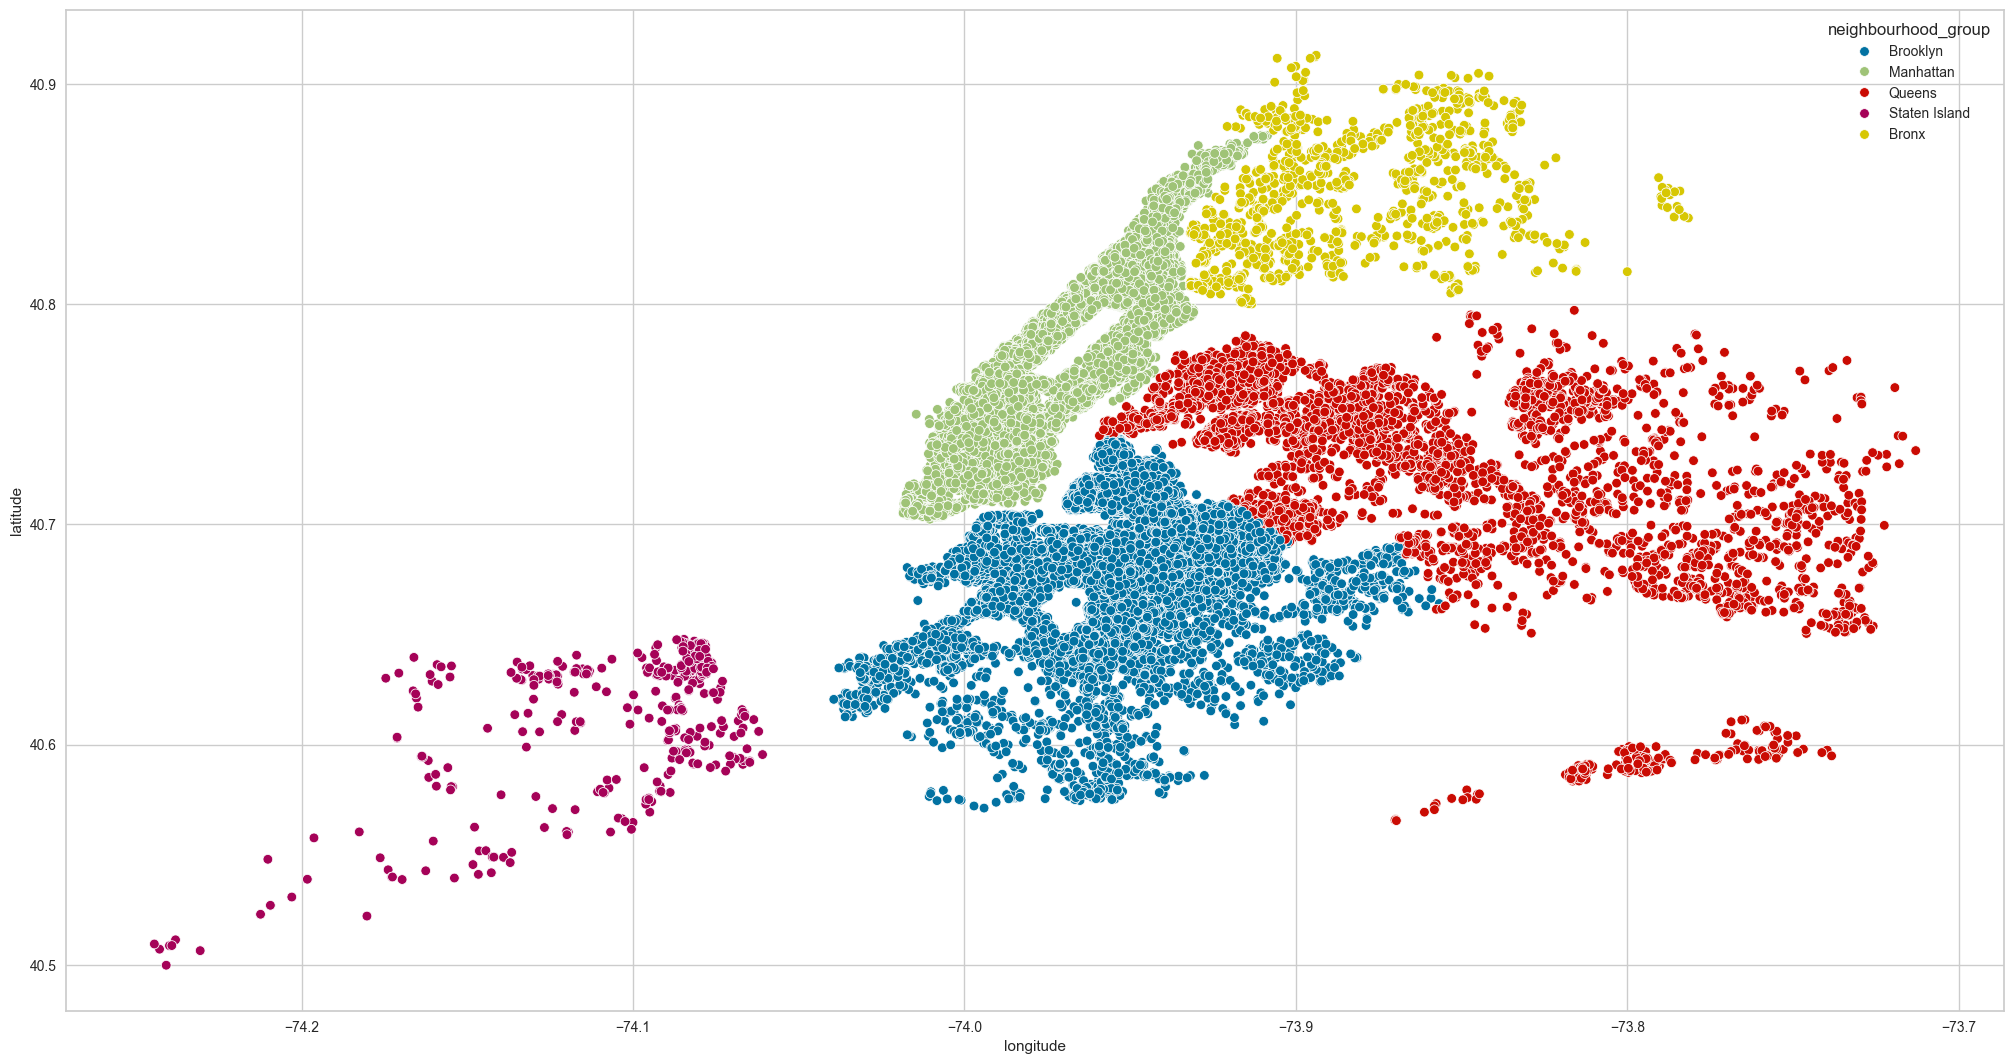

In [19]:
plt.figure(figsize=(25,13))
sns.scatterplot(x=df_ny['longitude'], y=df_ny['latitude'], hue=df_ny['neighbourhood_group'])
plt.show()

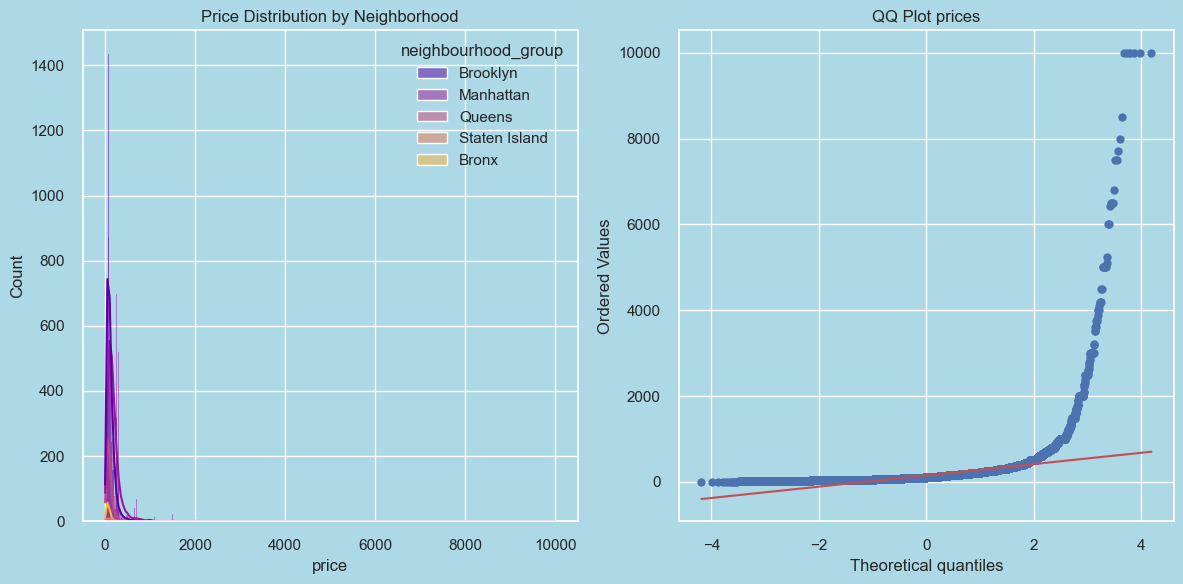

In [17]:
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightblue'})

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df_ny, x="price", hue="neighbourhood_group", fill=True, common_norm=False, palette="plasma", alpha=0.5, kde=True, ax=ax[0])
ax[0].set_title('Price Distribution by Neighborhood')

stats.probplot(df_ny['price'], dist="norm", plot=ax[1])
ax[1].set_title('QQ Plot prices')

plt.tight_layout()
plt.show()


<b><span style="color:purple">Conclusions</span></b>

The price distribution does not follow a normal distribution and we can see a large number of outliers, the distribution has a positive asymmetry

<Axes: xlabel='count', ylabel='neighbourhood_group'>

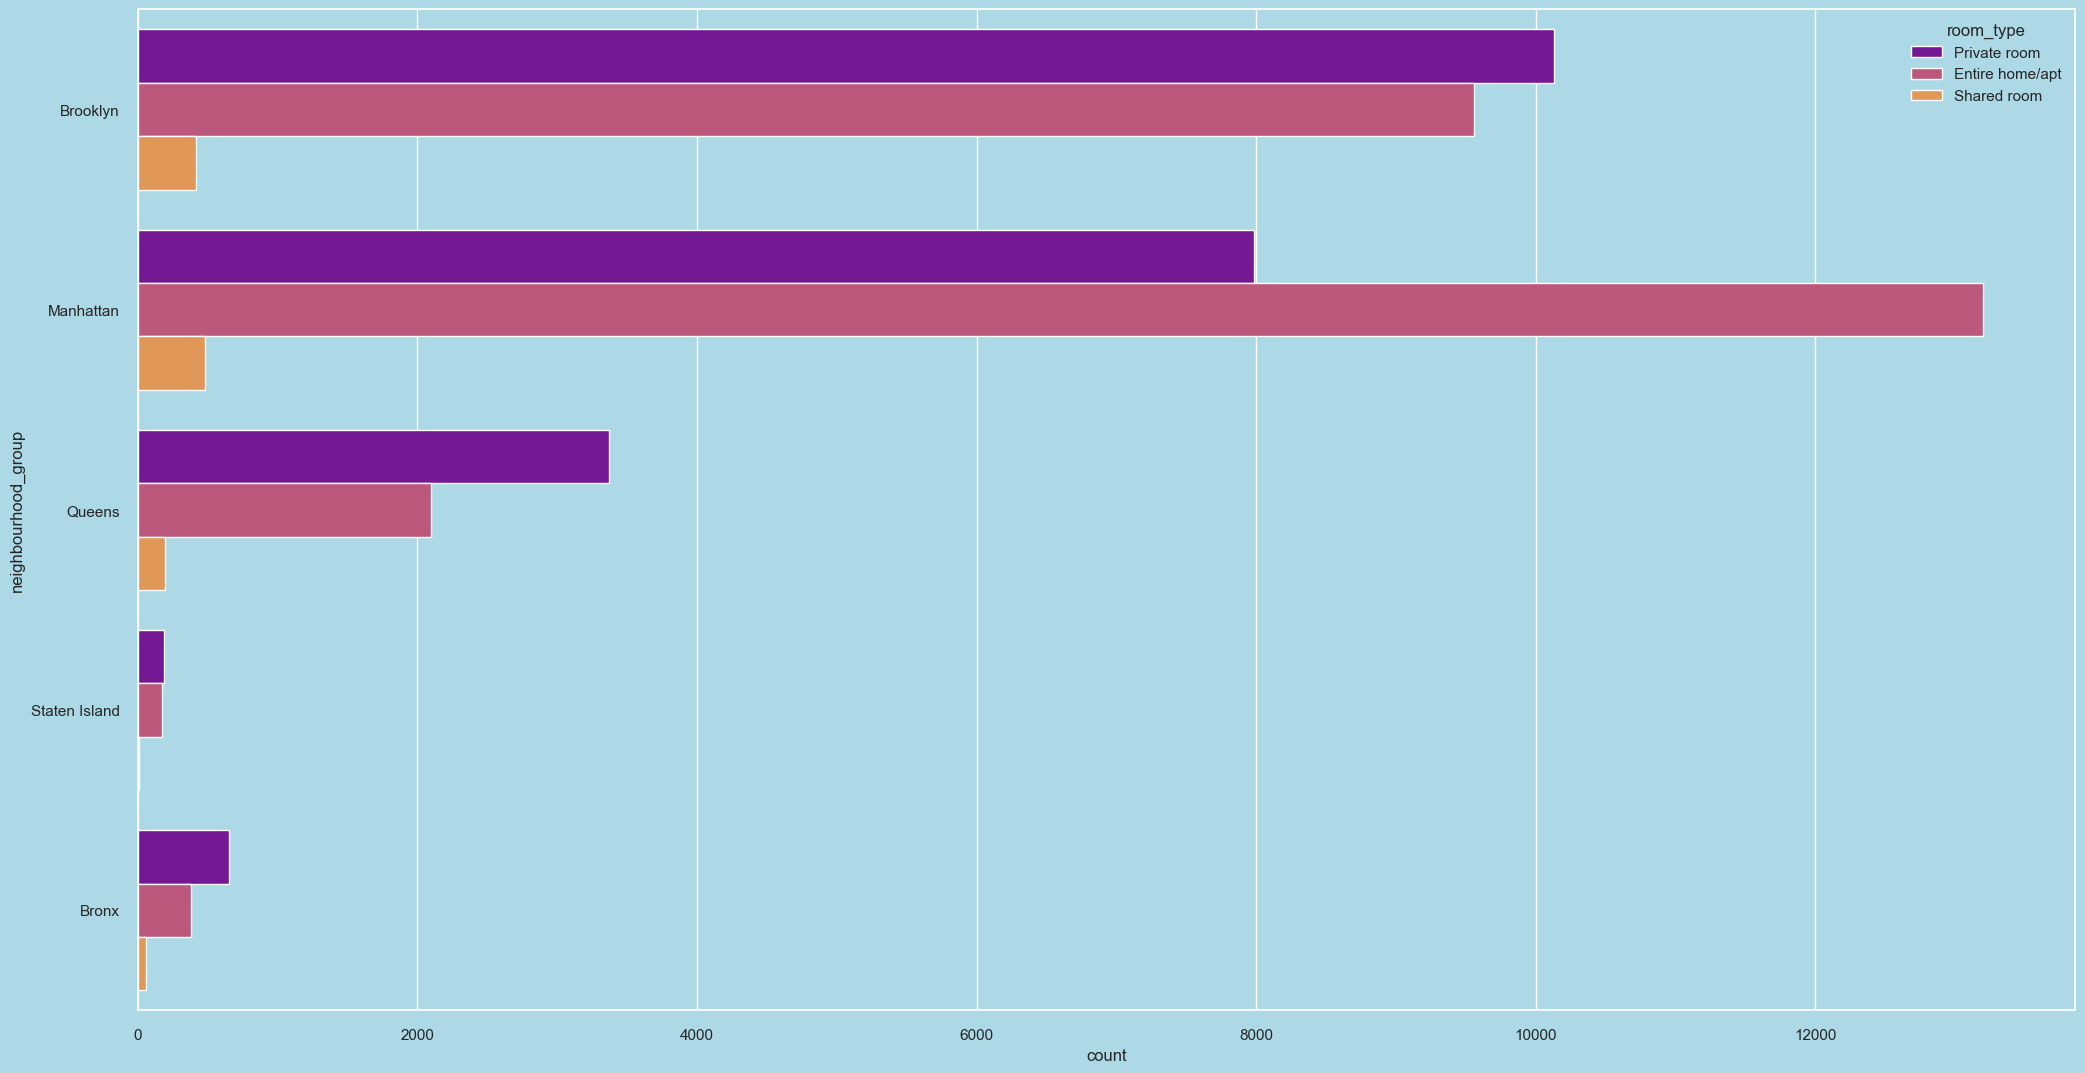

In [18]:
plt.figure(figsize=(25,13))
sns.countplot(y ='neighbourhood_group', hue = "room_type", data = df_ny,palette='plasma')

<b><span style="color:purple">Conclusions</span></b>

Now we can graphically see the conclusions made in the descriptive statistics of the variables

<Axes: xlabel='neighbourhood_group', ylabel='price'>

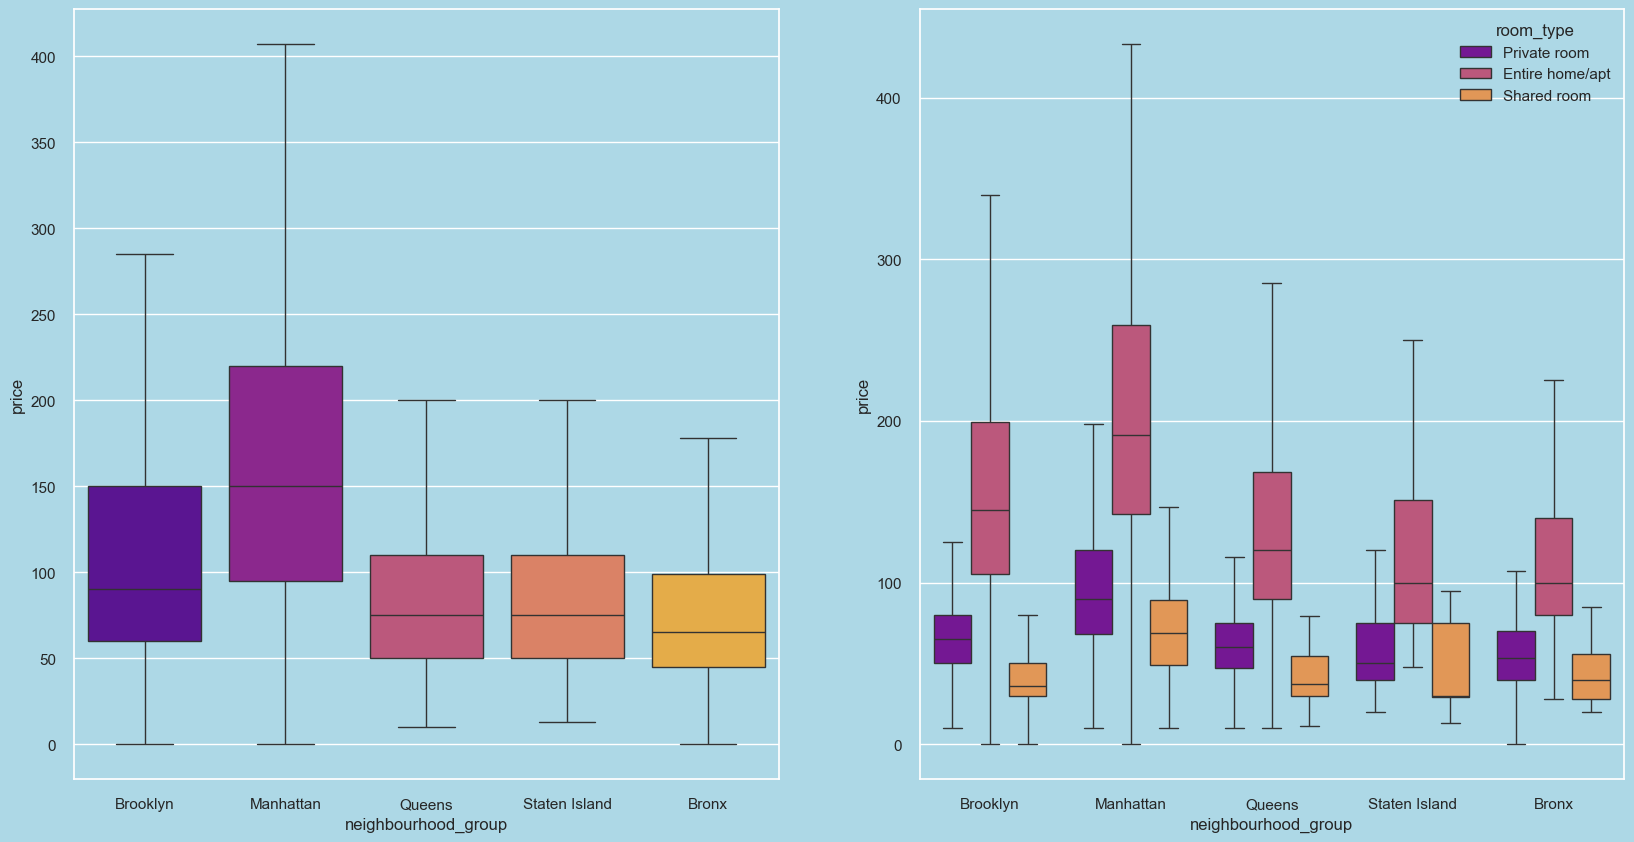

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

sns.boxplot(x='neighbourhood_group', y='price', data=df_ny, showfliers = False, palette='plasma', ax=ax[0])

sns.boxplot(x='neighbourhood_group', y='price', hue='room_type',data=df_ny, showfliers = False, palette='plasma',ax=ax[1])


<b><span style="color:purple">Conclusions</span></b>

We see a wider range of prices in Manhattan indicating the great variability seen previously as it is an area with many historical, tourism, luxury and business activity points. The presence of several outliers is clear. Later we will remove these outliers and focus on an analysis that prioritizes healthy prices, excluding possible luxurious places that bring asymmetry.
The cheapest prices are located in Queens, Staten Island and Bronx

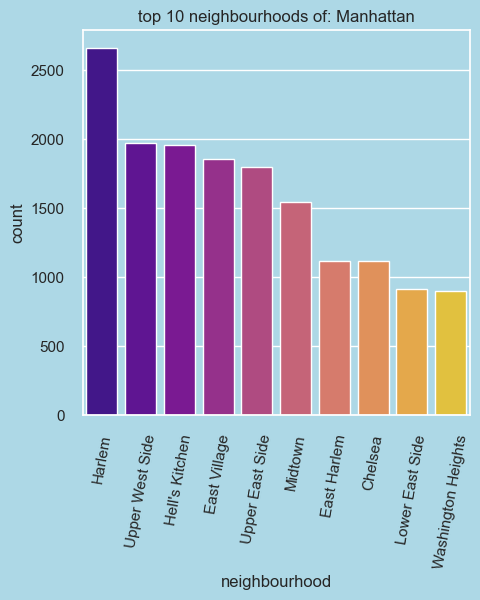

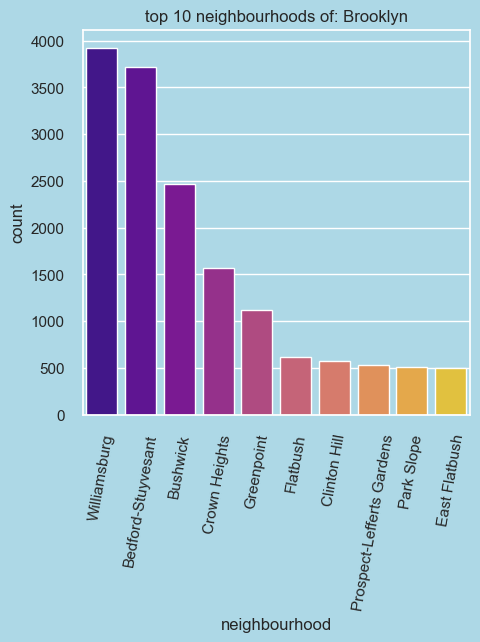

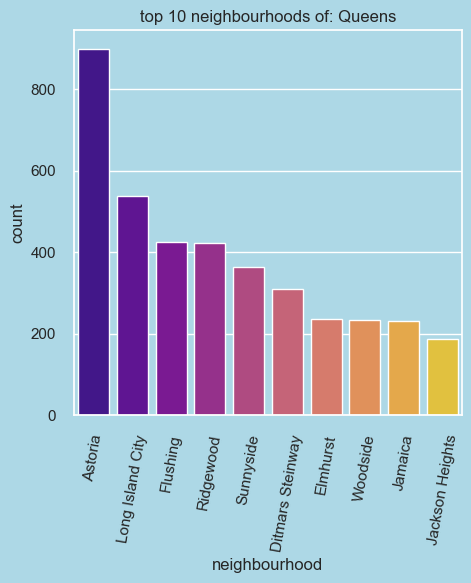

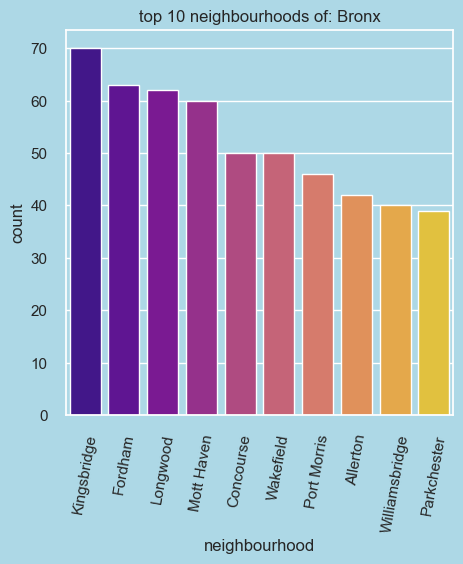

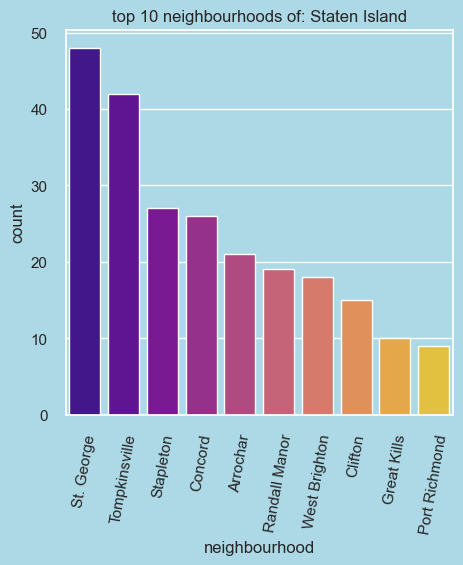

In [23]:
man2 = man['neighbourhood'].value_counts().head(10).reset_index()
brook2 = brook['neighbourhood'].value_counts().head(10).reset_index()
queens2=queens['neighbourhood'].value_counts().head(10).reset_index()
bronx2=bronx['neighbourhood'].value_counts().head(10).reset_index()
stti2 =stti['neighbourhood'].value_counts().head(10).reset_index()
list2=[man2, brook2,queens2,bronx2,stti2]

count=0
group = df_ny['neighbourhood_group'].value_counts().reset_index()
for i in list2:
    
    plt.figure(figsize=(5, 5))
    sns.barplot(x='index', y='neighbourhood', data=i, palette='plasma')
    plt.title('top 10 neighbourhoods of: {}'.format(group.iloc[count,0]))
    plt.xlabel('neighbourhood')
    plt.ylabel('count')
    plt.xticks(rotation=80)
    plt.show()
    count+=1

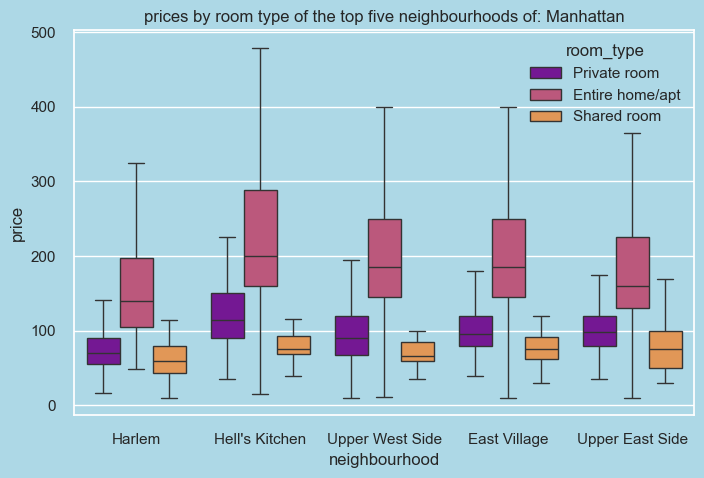

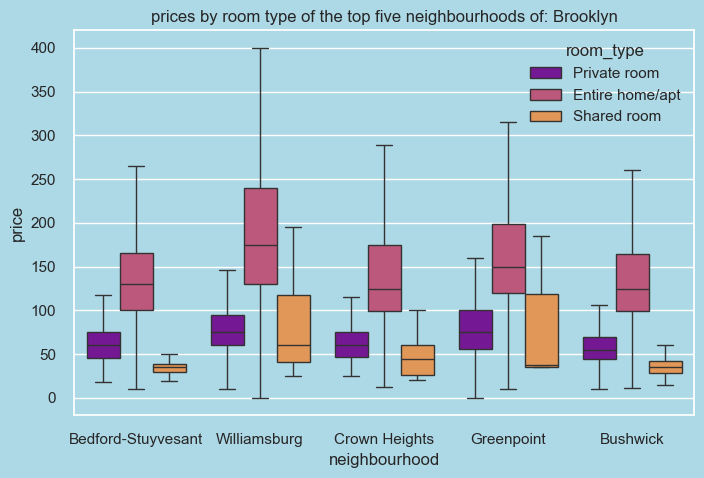

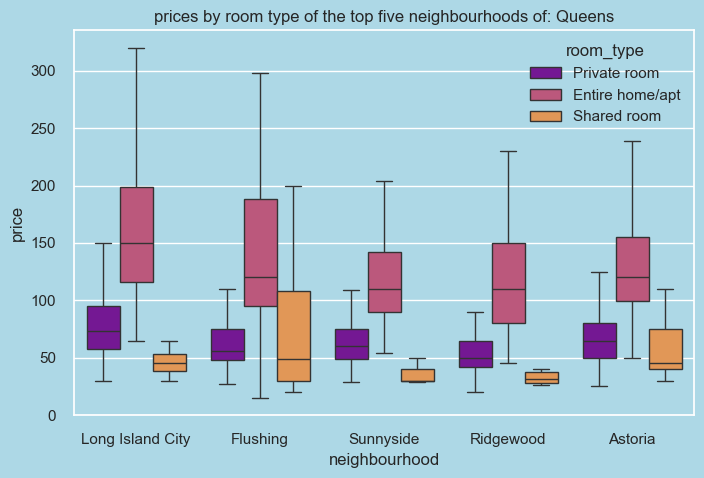

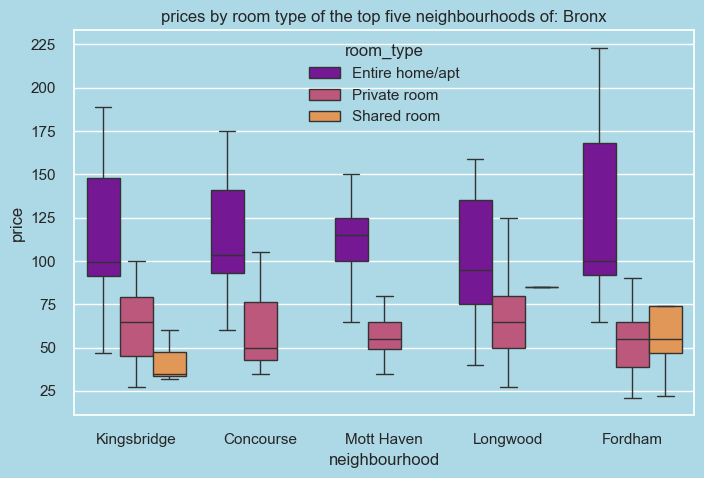

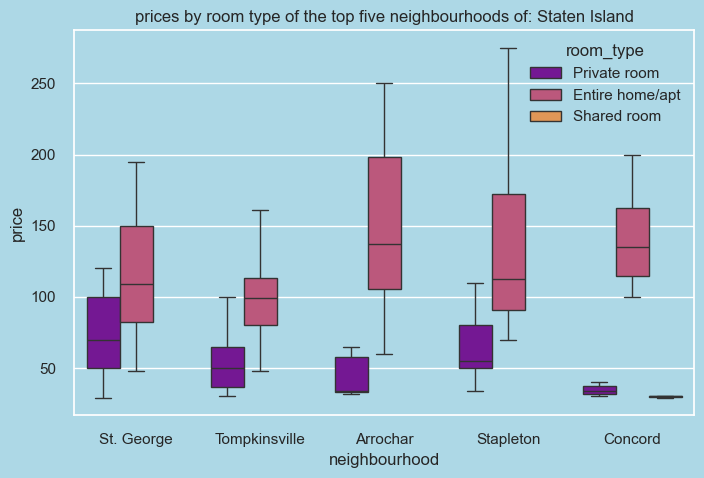

In [20]:
man3 = df_ny[df_ny['neighbourhood'].isin(['Harlem','Upper West Side',"Hell's Kitchen",'East Village','Upper East Side'])]
brook3 = df_ny[df_ny['neighbourhood'].isin(['Williamsburg','Bedford-Stuyvesant',"Bushwick",'Crown Heights','Greenpoint'])]
queens3=df_ny[df_ny['neighbourhood'].isin(['Astoria','Long Island City',"Flushing",'Ridgewood','Sunnyside'])]
bronx3=df_ny[df_ny['neighbourhood'].isin(['Kingsbridge','Fordham',"Longwood",'Mott Haven','Concourse'])]
stti3 =df_ny[df_ny['neighbourhood'].isin(['St. George','Tompkinsville',"Stapleton",'Concord','Arrochar'])]
list3=  [man3,brook3,queens3,bronx3,stti3]

count=0
group = df_ny['neighbourhood_group'].value_counts().reset_index()

for i in list3:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='neighbourhood', y='price', hue='room_type',data=i, showfliers = False, palette='plasma')
    plt.title('prices by room type of the top five neighbourhoods of: {}'.format(group.iloc[count,0]))
    count+=1


<Axes: >

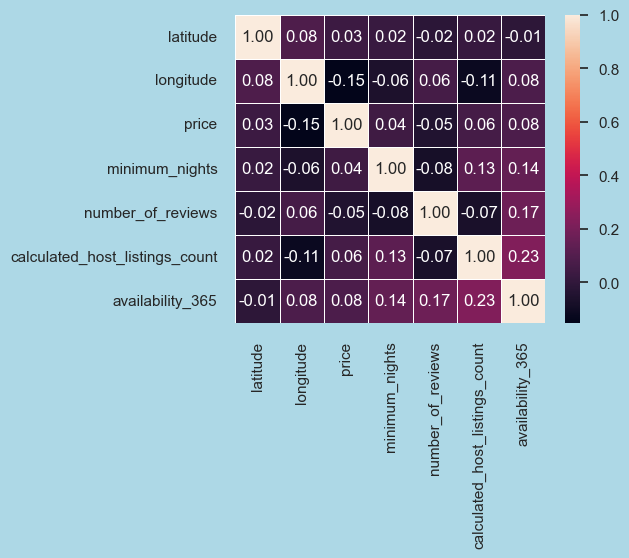

In [21]:
correlation = df_ny.corr()

plt.figure(figsize=(5,4))
sns.heatmap(correlation,annot=True,
    fmt='.2f',
    linewidths=0.5,
    linecolor='white')

<b><span style="color:purple">Conclusions</span></b>


With the correlation analysis we can verify that we do not have any strong correlation with price, let's remove the outliers to see the numbers more clearly

### <b><span style="color:orange"> Pre Processing

In [22]:
def find_outlier_iqr(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers_list = []
    
    for value in df[column].values:
        if value > upper or value < lower:
            outliers_list.append(np.nan)
        else:
            outliers_list.append(value)
        
    print("Outliers number detected: {}".format(outliers_list.count(np.nan)))
    return outliers_list

def drop_outlier(df):
    return df.dropna()

In [23]:
columns_check = ['price']

for column in columns_check:
    df_ny[column] = find_outlier_iqr(df_ny,column)

Outliers number detected: 2972


In [24]:
df_ny.isnull().sum()

name                                16
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                             2972
minimum_nights                       0
number_of_reviews                    0
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [25]:
df_ny = drop_outlier(df_ny)
df_ny.isnull().sum()

name                              0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Now let's check the data distributions again after removing the outliers

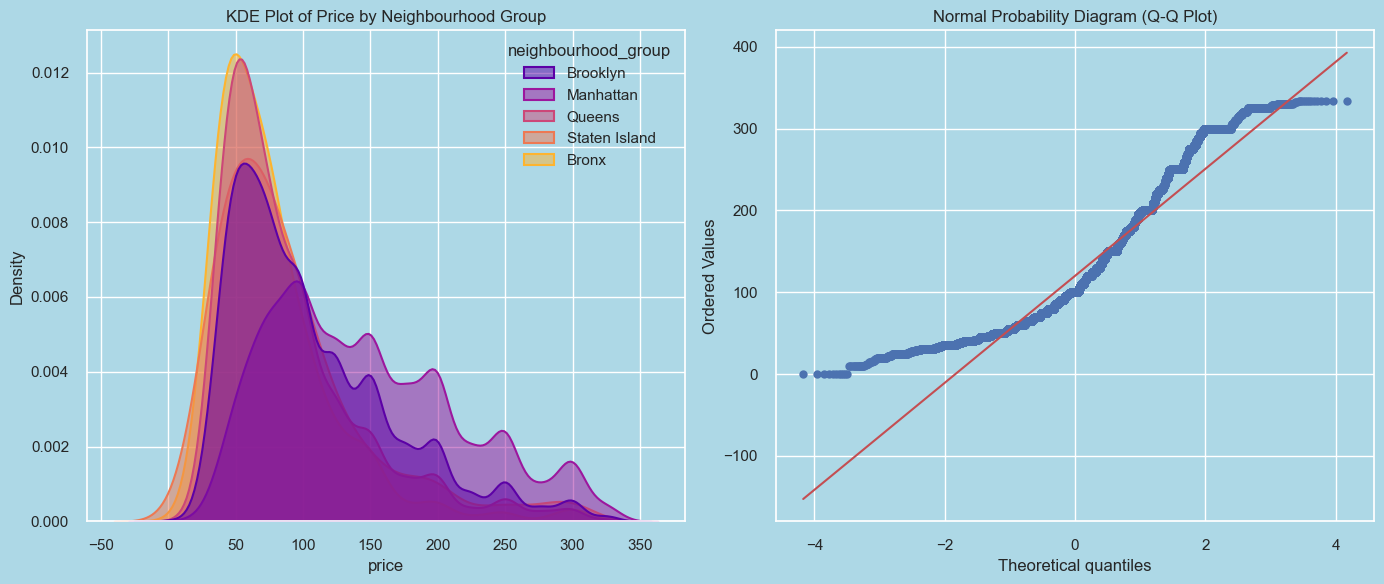

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(data=df_ny, x="price", hue="neighbourhood_group", fill=True, common_norm=False, palette="plasma",alpha=.5, linewidth=1.5, 
    ax=axes[0])
axes[0].set_title('KDE Plot of Price by Neighbourhood Group')

# Q-Q plot
stats.probplot(df_ny['price'], dist="norm", plot=axes[1])
axes[1].set_title('Normal Probability Diagram (Q-Q Plot)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

<Axes: >

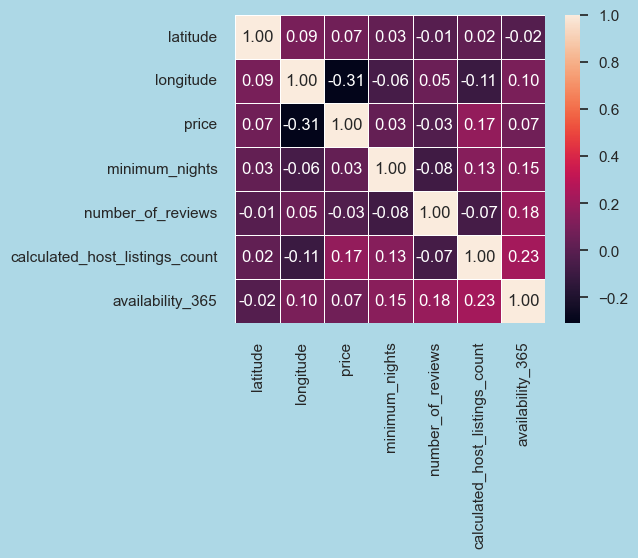

In [27]:
correlation = df_ny.corr()

plt.figure(figsize=(5,4))
sns.heatmap(correlation,annot=True,
    fmt='.2f',
    linewidths=0.5,
    linecolor='white')


In [28]:
print("\033[1;33;40m Price Mean through neighborhoods\033[0m");
neighs6 = df_ny[['price','neighbourhood_group']].groupby('neighbourhood_group').agg({"price": [np.mean]})
neighs6['price with outlier'] = neighs.iloc[:,0] 
neighs6['percentage of variation after removing'] = (neighs6.iloc[:,0] - neighs.iloc[:,0])/neighs.iloc[:,0]
neighs6

 Price Mean through neighborhoods


,price,price with outlier,percentage of variation after removing
,mean,,
neighbourhood_group,,,
Bronx,77.316183,87.496792,-0.116354
Brooklyn,105.706786,124.383207,-0.150152
Manhattan,145.944148,196.875814,-0.258699
Queens,88.904437,99.517649,-0.106647
Staten Island,89.235616,114.812332,-0.222770


In [32]:
#neighs_with_outliers = neighs.iloc[:,0]
#with_outliers = neighs_with_outliers.reset_index().drop(['neighbourhood_group'],axis=1)
#with_outliers.columns = with_outliers.columns.droplevel(0)
#with_outliers

In [29]:
print("\033[1;33;40m Price through Manhattan neighborhoods and type of room\033[0m");
man6 = df_ny[df_ny['neighbourhood'].isin(['Harlem','Upper West Side',"Hell's Kitchen",'East Village','Upper East Side'])]
man_anal = man6.groupby(['neighbourhood_group','neighbourhood','room_type']).agg({"price": ['mean','min','max','std']})
man_anal

 Price through Manhattan neighborhoods and type of room


price               \
                                                           mean   min    max   
neighbourhood_group neighbourhood   room_type                                  
Manhattan           East Village    Entire home/apt  183.155620  10.0  330.0   
                                    Private room     103.707692  39.0  300.0   
                                    Shared room       72.000000  30.0  120.0   
                    Harlem          Entire home/apt  147.526749  49.0  325.0   
                                    Private room      77.166347  16.0  300.0   
                                    Shared room       68.081633  10.0  235.0   
                    Hell's Kitchen  Entire home/apt  193.916327  15.0  330.0   
                                    Private room     122.838168  35.0  308.0   
                                    Shared room       83.031579  10.0  299.0   
                    Upper East Side Entire home/apt  168.785235  10.0  328.0   
                                    Private room     104.617169  35.0  301.0   
                                    Shared room       83.808511  30.0  209.0   
                    Upper West Side Entire home/apt  180.510110  11.0  333.0   
                                    Private room      99.639394  10.0  325.0   
                                    Shared room       84.846154  35.0  300.0   

                                                                
                                                           std  
neighbourhood_group neighbourhood   room_type                   
Manhattan           East Village    Entire home/apt  59.217808  
                                    Private room     41.520271  
                                    Shared room      23.565512  
                    Harlem          Entire home/apt  58.533189  
                                    Private room     34.356782  
                                    Shared room      43.616146  
                    Hell's Kitchen  Entire home/apt  59.586241  
                                    Private room     48.394891  
                                    Shared room      38.608634  
                    Upper East Side Entire home/apt  55.734324  
                                    Private room     43.742689  
                                    Shared room      42.690819  
                    Upper West Side Entire home/apt  61.442293  
                                    Private room     47.897339  
                                    Shared room      53.072710

<b><span style="color:purple">Conclusions</span></b>


* After treatment, the asymmetry continues, but the visualization has improved and with the qq plot we can see that the data is better distributed than before
* After removing the outliers we can see that the correlation of price with longitude for example has increased in 106%
* We can conclude that the neighborhood most affected by outliers was Manhattan
* Now we can check prices without outliers with more certainty that we will observe healthy prices
* By selecting <span style="color:cyan">Manhattan</span> 🗽 (or any other neighborhood following the same logic, I will only exemplify Manhattan for learning purposes and not make a very extensive grouping that will pollute the notebook) we can now check which type of airbnb and in which neighborhood with a low cost is more worthwhile:
     * ✅ The most affordable Entire home/apt is in Harlem at 💲147.53.
     * ✅ The most affordable Private room is in Harlem at 💲77.17.
     * ✅ The most affordable Shared room is also in Harlem at 💲68.08.
     * ✅ Thus, Harlem is the most affordable neighborhood across all room types based on the mean prices
* If later the intention is to analyze more expensive places, we can transform the outliers into business analysis

### <b><span style="color:orange">Machine Learning

Since we've already dealt with nulls and outliers, some prices are 0 I will remove them so as not to harm the model. Our target variable will be the Price, I will use the attributes 'neighbourhood_group', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365' as independent variables.

<b>Categorical Enconding</b><br>
I will use the one hot encoding technique for 'neighbourhood_group' and 'room_type' since our categorical data does not have an order of magnitude and we have few options of categories

<b>Split</b><br>
I will use the Hold out method which consists of 70% of the data for training and 30% for testing

<b>Performance Metrics</b><br>
* R^2
* Root Mean Squared Error (RMSE)
* Mean Absolute Percentage Error (MAPE)

In [136]:
def metrics(y_test,y_pred):
    r2 = r2_score(y_test,predict) ; print("\033[1;33;40m R^2:\033[0m",r2)
    rmse = mean_squared_error(y_test,predict,squared=False) ; print("\033[1;33;40m RMSE:\033[0m",rmse)
    mape = mean_absolute_percentage_error(y_test,predict) * 100 ; print(f"\033[1;33;40m MAPE:\033[0m {mape:.2f}%")

In [115]:
ml = df_ny[['neighbourhood_group', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365']]

print('\033[1mNumeric Attributes:\033[0m') ; print(ml.select_dtypes(include=np.number).columns)
print('-'*40)
print('\033[1mCategorical Attributes:\033[0m') ; print(ml.select_dtypes(exclude=np.number).columns)



Numeric Attributes:
Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
----------------------------------------
Categorical Attributes:
Index(['neighbourhood_group', 'room_type'], dtype='object')


In [116]:
mask = ml[ml['price'] == 0]
ml = ml.drop(mask.index,axis=0)

In [117]:
ml = pd.get_dummies(data=ml,columns=['neighbourhood_group','room_type'])

x = ml.drop('price',axis=1)
y = ml['price']

scaler = StandardScaler().fit(x)
x = scaler.transform(x)


#### Linear Regression

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=.7,random_state=1)

linear = LinearRegression()

linear.fit(x_train,y_train)

predict = linear.predict(x_test)

metrics(y_test,predict)

 R^2: 0.49017295557265017
 RMSE: 48.796793856611615
 MAPE: 36.15%


#### Decision Tree

In [142]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=.7,random_state=1)

tree = DecisionTreeRegressor()

tree.fit(x_train,y_train)

predict = tree.predict(x_test)

metrics(y_test, predict)

 R^2: 0.16111638025262964
 RMSE: 62.593712459848334
 MAPE: 41.04%


#### Enseamble Learning - Random Forest

In [143]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=.7,random_state=1)

ens = RandomForestRegressor(n_estimators=120)

ens.fit(x_train,y_train)

predict = ens.predict(x_test)

metrics(y_test, predict)

 R^2: 0.5722923703890477
 RMSE: 44.69442475998091
 MAPE: 30.83%


<b><span style="color:purple">Conclusions</span></b><br>
The best model was Random Forest with reasonable performance as R^2 is moderately high, but there is still room for improvement as RMSE and MAPE can be reduced. Later we can adjust the hyperparameters to bring an improvement to the model